# Мультикласова 3 мобілка

In [ ]:
from google.colab import drive
import zipfile
import os
import numpy as np
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import torch
from torchvision import transforms
from torchvision.models import mobilenet_v3_large
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from accelerate import Accelerator

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/class_fragments.zip"
extract_path = "extracted_files"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

DATA_DIR = os.path.join(extract_path, 'class_fragments')

def create_dataframe(directory):
    image_path = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path.append(os.path.join(label_path, image_name))
                labels.append(label)
    return image_path, labels

image_paths, labels = create_dataframe(DATA_DIR)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(
    image_paths, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        return {
            "pixel_values": img,
            "labels": torch.tensor(label, dtype=torch.long)
        }

model = mobilenet_v3_large(pretrained=True)
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, len(le.classes_))

train_dataset = ImageDataset(x_train, y_train, transform)
test_dataset = ImageDataset(x_test, y_test, transform)

BATCH_SIZE = 64
EPOCHS = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_encoded),
    y=labels_encoded
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

accelerator = Accelerator()
model, optimizer, train_loader, test_loader = accelerator.prepare(
    model, optimizer, train_loader, test_loader
)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values)
        loss = criterion(outputs, labels)
        accelerator.backward(loss)
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(pixel_values)
        _, preds = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 84.5MB/s]
100%|██████████| 218/218 [01:26<00:00,  2.53it/s]


Epoch 1/6, Loss: 1.0088


100%|██████████| 218/218 [01:21<00:00,  2.68it/s]


Epoch 2/6, Loss: 0.2999


100%|██████████| 218/218 [01:20<00:00,  2.70it/s]


Epoch 3/6, Loss: 0.1810


100%|██████████| 218/218 [01:20<00:00,  2.72it/s]


Epoch 4/6, Loss: 0.1261


100%|██████████| 218/218 [01:21<00:00,  2.69it/s]


Epoch 5/6, Loss: 0.0792


100%|██████████| 218/218 [01:30<00:00,  2.41it/s]


Epoch 6/6, Loss: 0.0516
Test Accuracy: 94.77%


Test Accuracy: 94.77%


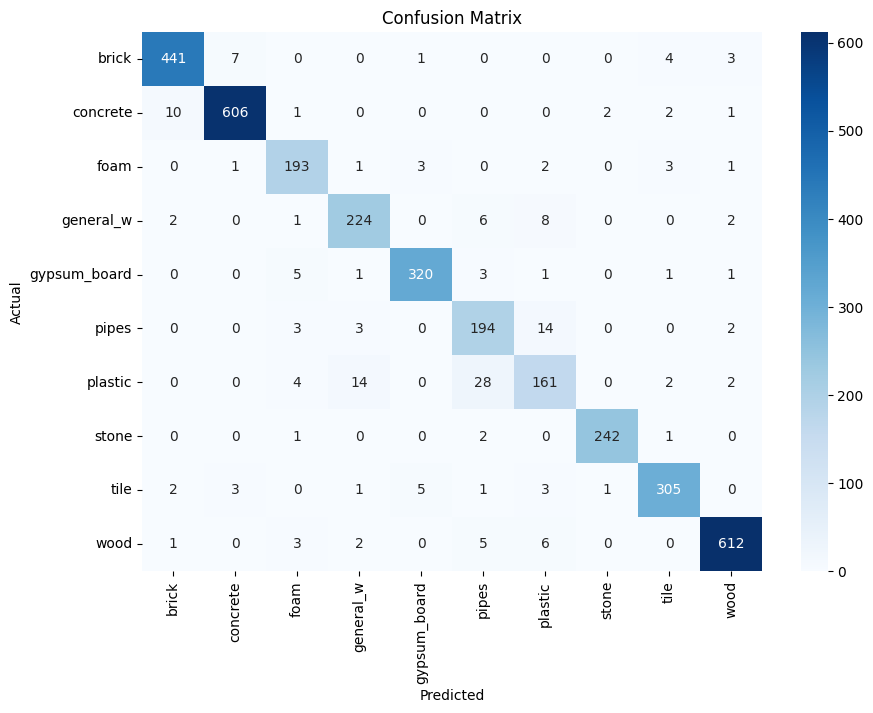

              precision    recall  f1-score   support

       brick       0.97      0.97      0.97       456
    concrete       0.98      0.97      0.98       622
        foam       0.91      0.95      0.93       204
   general_w       0.91      0.92      0.92       243
gypsum_board       0.97      0.96      0.97       332
       pipes       0.81      0.90      0.85       216
     plastic       0.83      0.76      0.79       211
       stone       0.99      0.98      0.99       246
        tile       0.96      0.95      0.95       321
        wood       0.98      0.97      0.98       629

    accuracy                           0.95      3480
   macro avg       0.93      0.93      0.93      3480
weighted avg       0.95      0.95      0.95      3480



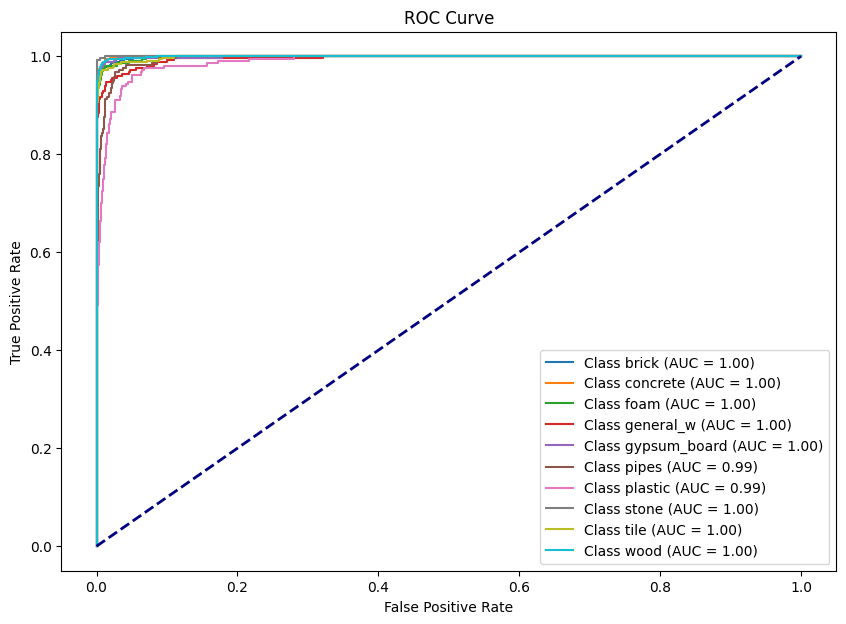

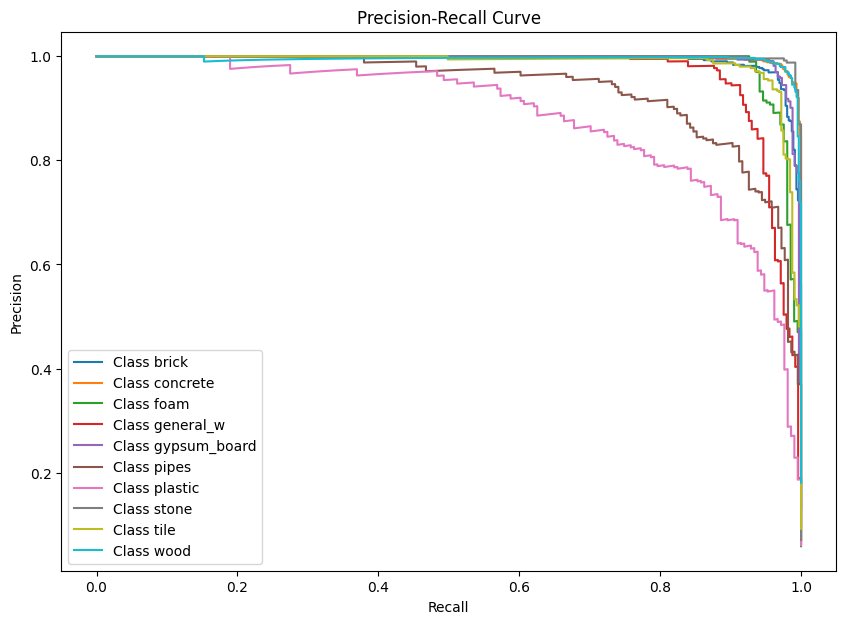

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns

model.eval()
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(pixel_values)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

print(f"Test Accuracy: {100 * np.mean(np.array(all_preds) == np.array(all_labels)):.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(all_labels, all_preds, target_names=le.classes_))

plt.figure(figsize=(10, 7))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
    plt.plot(fpr, tpr, label=f'Class {le.classes_[i]} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
for i in range(len(le.classes_)):
    precision, recall, _ = precision_recall_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
    plt.plot(recall, precision, label=f'Class {le.classes_[i]}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Бінарні 3 мобілка

Mounted at /content/drive
Training for class: brick


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 161MB/s]
100%|██████████| 218/218 [01:21<00:00,  2.68it/s]


Epoch 1/6, Loss: 0.1955


100%|██████████| 218/218 [01:19<00:00,  2.74it/s]


Epoch 2/6, Loss: 0.0473


100%|██████████| 218/218 [01:20<00:00,  2.70it/s]


Epoch 3/6, Loss: 0.0247


100%|██████████| 218/218 [01:19<00:00,  2.74it/s]


Epoch 4/6, Loss: 0.0143


100%|██████████| 218/218 [01:22<00:00,  2.65it/s]


Epoch 5/6, Loss: 0.0115


100%|██████████| 218/218 [01:21<00:00,  2.69it/s]


Epoch 6/6, Loss: 0.0076
Test Accuracy for brick: 99.25%


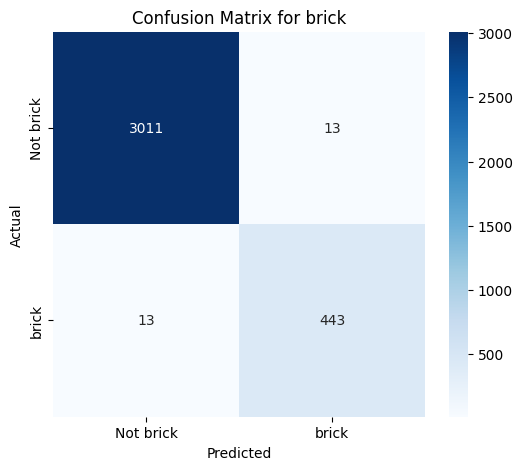

              precision    recall  f1-score   support

   Not brick       1.00      1.00      1.00      3024
       brick       0.97      0.97      0.97       456

    accuracy                           0.99      3480
   macro avg       0.98      0.98      0.98      3480
weighted avg       0.99      0.99      0.99      3480



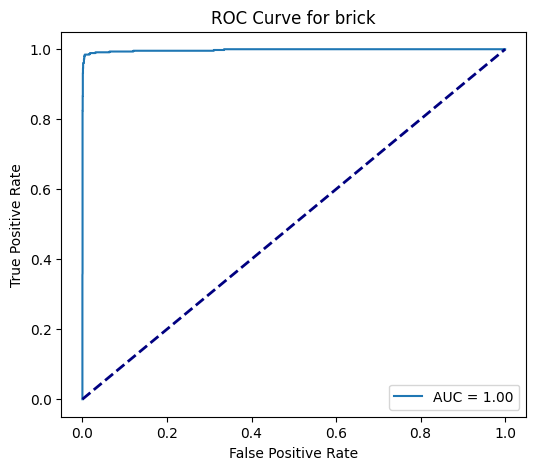

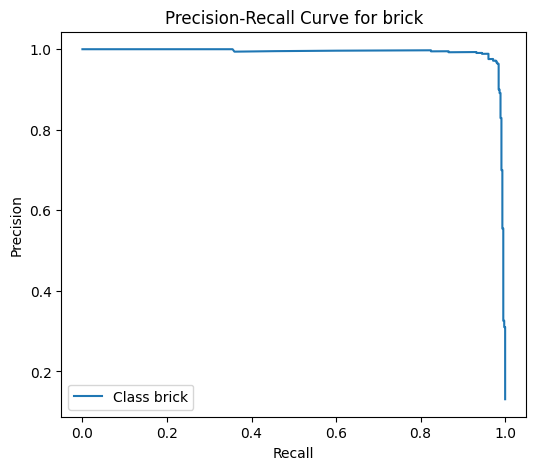

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training for class: concrete


100%|██████████| 218/218 [01:15<00:00,  2.87it/s]


Epoch 1/6, Loss: 0.1175


100%|██████████| 218/218 [01:16<00:00,  2.84it/s]


Epoch 2/6, Loss: 0.0350


100%|██████████| 218/218 [01:15<00:00,  2.90it/s]


Epoch 3/6, Loss: 0.0182


100%|██████████| 218/218 [01:15<00:00,  2.90it/s]


Epoch 4/6, Loss: 0.0120


100%|██████████| 218/218 [01:15<00:00,  2.88it/s]


Epoch 5/6, Loss: 0.0067


100%|██████████| 218/218 [01:14<00:00,  2.91it/s]


Epoch 6/6, Loss: 0.0050
Test Accuracy for concrete: 99.28%


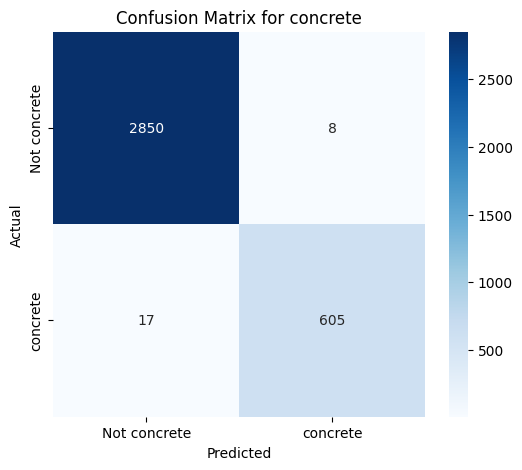

              precision    recall  f1-score   support

Not concrete       0.99      1.00      1.00      2858
    concrete       0.99      0.97      0.98       622

    accuracy                           0.99      3480
   macro avg       0.99      0.98      0.99      3480
weighted avg       0.99      0.99      0.99      3480



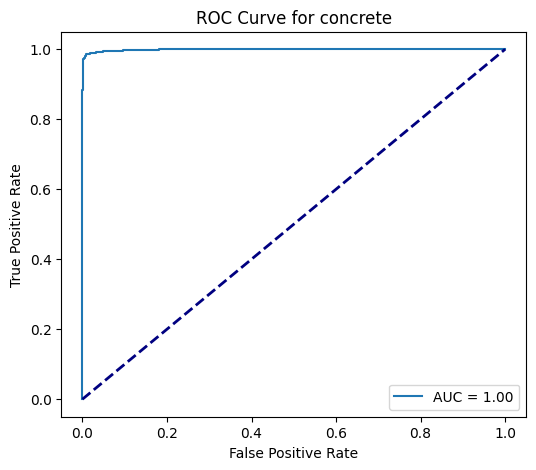

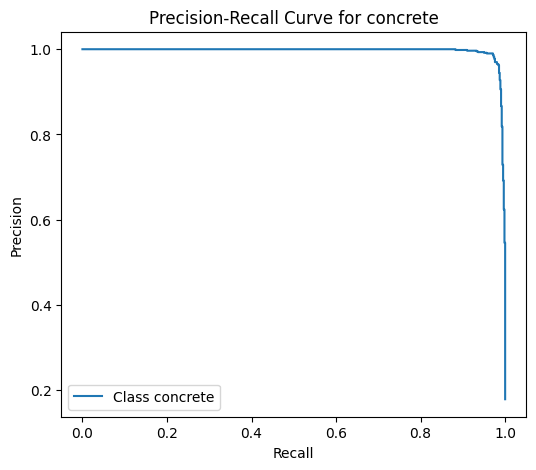

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training for class: foam


100%|██████████| 218/218 [01:14<00:00,  2.93it/s]


Epoch 1/6, Loss: 0.2096


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 2/6, Loss: 0.0366


100%|██████████| 218/218 [01:15<00:00,  2.91it/s]


Epoch 3/6, Loss: 0.0165


100%|██████████| 218/218 [01:14<00:00,  2.91it/s]


Epoch 4/6, Loss: 0.0093


100%|██████████| 218/218 [01:15<00:00,  2.88it/s]


Epoch 5/6, Loss: 0.0038


100%|██████████| 218/218 [01:15<00:00,  2.91it/s]


Epoch 6/6, Loss: 0.0033
Test Accuracy for foam: 99.71%


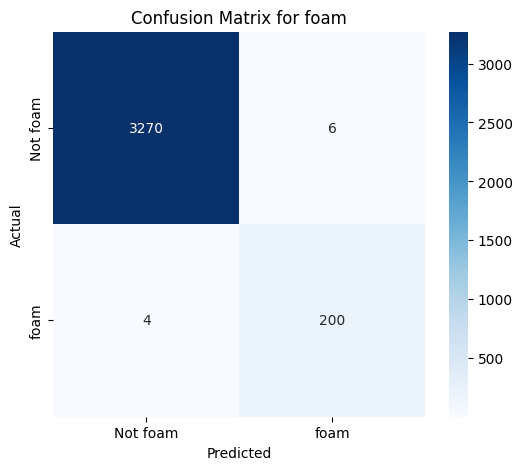

              precision    recall  f1-score   support

    Not foam       1.00      1.00      1.00      3276
        foam       0.97      0.98      0.98       204

    accuracy                           1.00      3480
   macro avg       0.98      0.99      0.99      3480
weighted avg       1.00      1.00      1.00      3480



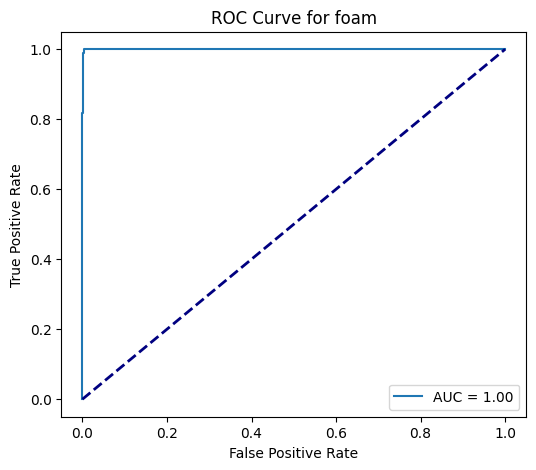

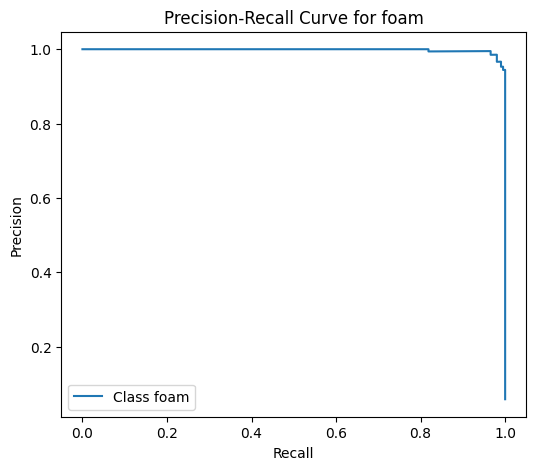

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training for class: general_w


100%|██████████| 218/218 [01:17<00:00,  2.80it/s]


Epoch 1/6, Loss: 0.2309


100%|██████████| 218/218 [01:17<00:00,  2.83it/s]


Epoch 2/6, Loss: 0.0768


100%|██████████| 218/218 [01:16<00:00,  2.86it/s]


Epoch 3/6, Loss: 0.0419


100%|██████████| 218/218 [01:16<00:00,  2.84it/s]


Epoch 4/6, Loss: 0.0258


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 5/6, Loss: 0.0125


100%|██████████| 218/218 [01:16<00:00,  2.86it/s]


Epoch 6/6, Loss: 0.0089
Test Accuracy for general_w: 98.25%


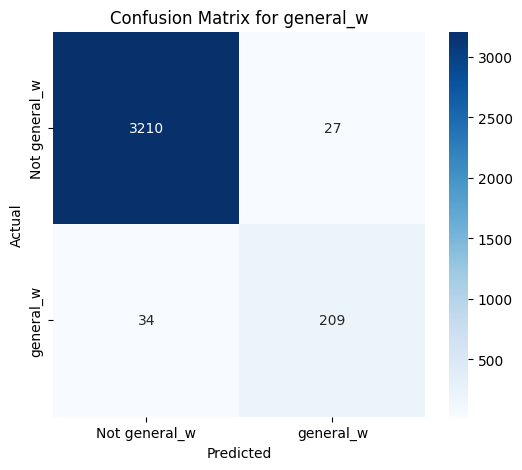

               precision    recall  f1-score   support

Not general_w       0.99      0.99      0.99      3237
    general_w       0.89      0.86      0.87       243

     accuracy                           0.98      3480
    macro avg       0.94      0.93      0.93      3480
 weighted avg       0.98      0.98      0.98      3480



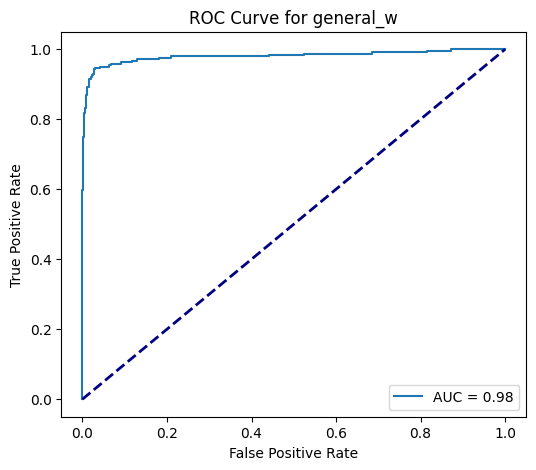

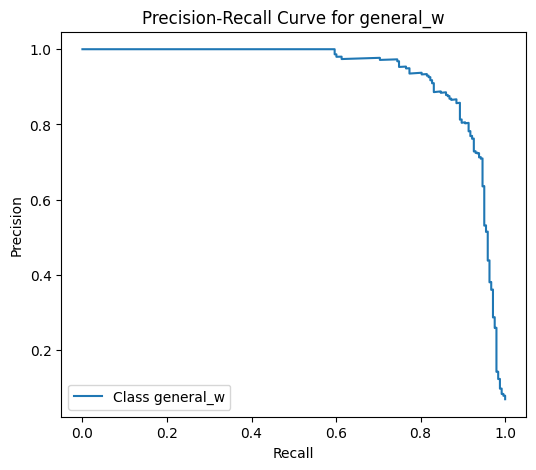

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training for class: gypsum_board


100%|██████████| 218/218 [01:16<00:00,  2.84it/s]


Epoch 1/6, Loss: 0.1713


100%|██████████| 218/218 [01:16<00:00,  2.86it/s]


Epoch 2/6, Loss: 0.0359


100%|██████████| 218/218 [01:16<00:00,  2.87it/s]


Epoch 3/6, Loss: 0.0161


100%|██████████| 218/218 [01:16<00:00,  2.84it/s]


Epoch 4/6, Loss: 0.0061


100%|██████████| 218/218 [01:16<00:00,  2.87it/s]


Epoch 5/6, Loss: 0.0038


100%|██████████| 218/218 [01:15<00:00,  2.87it/s]


Epoch 6/6, Loss: 0.0030
Test Accuracy for gypsum_board: 99.45%


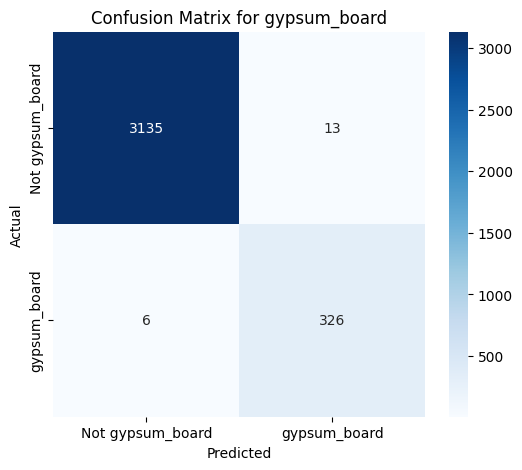

                  precision    recall  f1-score   support

Not gypsum_board       1.00      1.00      1.00      3148
    gypsum_board       0.96      0.98      0.97       332

        accuracy                           0.99      3480
       macro avg       0.98      0.99      0.98      3480
    weighted avg       0.99      0.99      0.99      3480



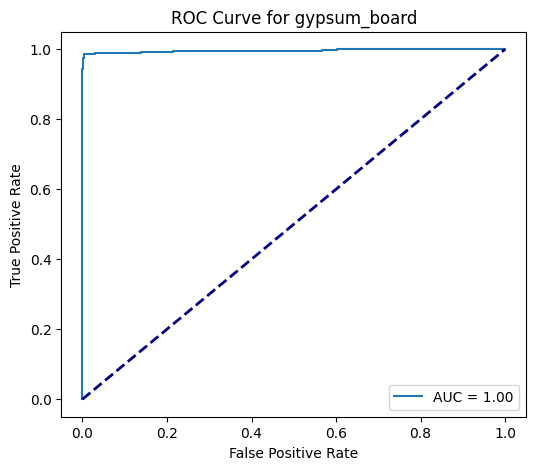

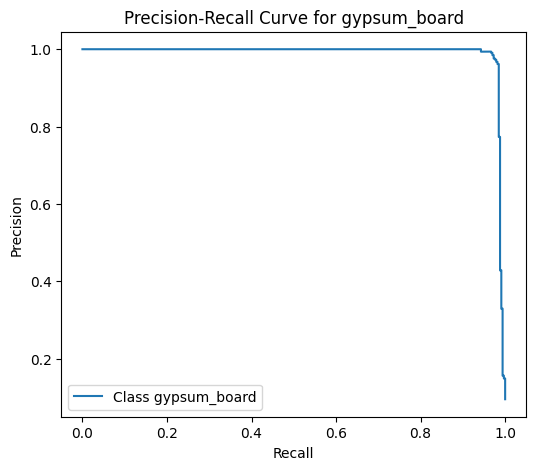

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training for class: pipes


100%|██████████| 218/218 [01:15<00:00,  2.88it/s]


Epoch 1/6, Loss: 0.2644


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 2/6, Loss: 0.0916


100%|██████████| 218/218 [01:15<00:00,  2.88it/s]


Epoch 3/6, Loss: 0.0487


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 4/6, Loss: 0.0347


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 5/6, Loss: 0.0234


100%|██████████| 218/218 [01:16<00:00,  2.86it/s]


Epoch 6/6, Loss: 0.0153
Test Accuracy for pipes: 97.73%


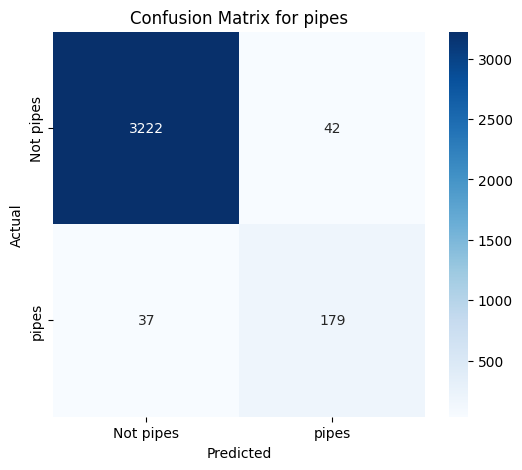

              precision    recall  f1-score   support

   Not pipes       0.99      0.99      0.99      3264
       pipes       0.81      0.83      0.82       216

    accuracy                           0.98      3480
   macro avg       0.90      0.91      0.90      3480
weighted avg       0.98      0.98      0.98      3480



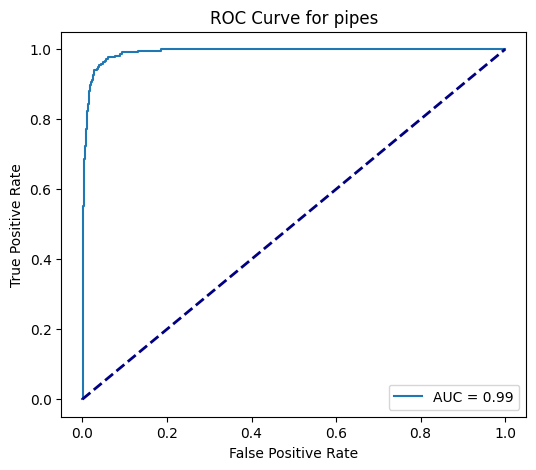

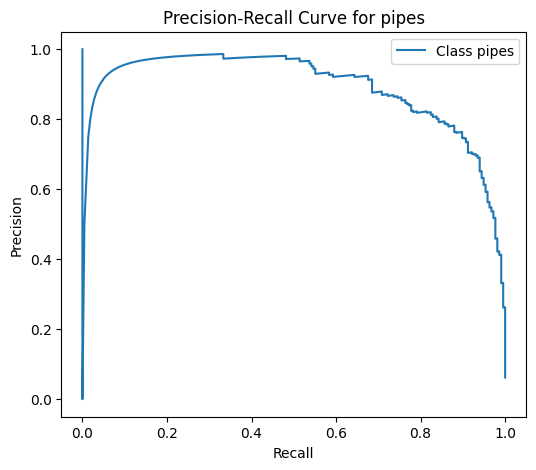

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training for class: plastic


100%|██████████| 218/218 [01:15<00:00,  2.90it/s]


Epoch 1/6, Loss: 0.3756


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 2/6, Loss: 0.1705


100%|██████████| 218/218 [01:16<00:00,  2.85it/s]


Epoch 3/6, Loss: 0.0992


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 4/6, Loss: 0.0568


100%|██████████| 218/218 [01:16<00:00,  2.87it/s]


Epoch 5/6, Loss: 0.0377


100%|██████████| 218/218 [01:14<00:00,  2.91it/s]


Epoch 6/6, Loss: 0.0260
Test Accuracy for plastic: 96.35%


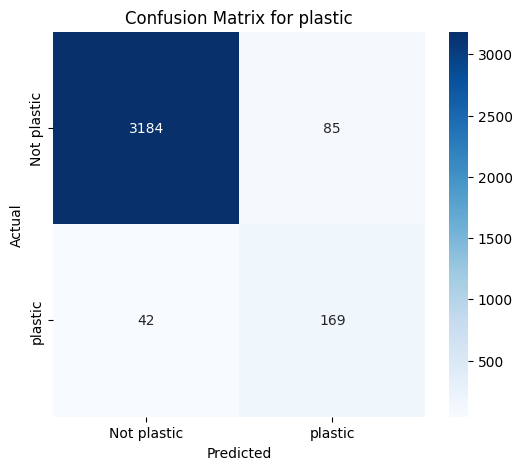

              precision    recall  f1-score   support

 Not plastic       0.99      0.97      0.98      3269
     plastic       0.67      0.80      0.73       211

    accuracy                           0.96      3480
   macro avg       0.83      0.89      0.85      3480
weighted avg       0.97      0.96      0.97      3480



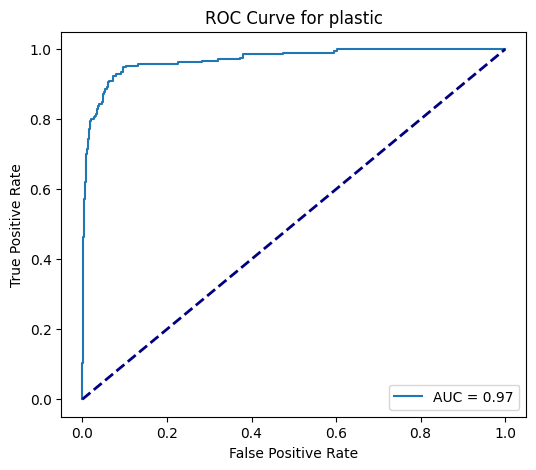

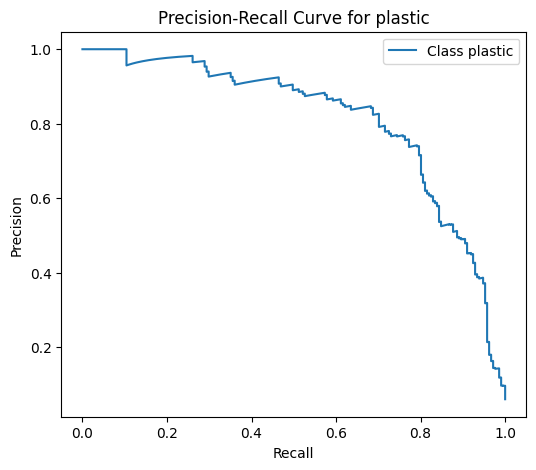

Training for class: stone


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 218/218 [01:15<00:00,  2.90it/s]


Epoch 1/6, Loss: 0.1450


100%|██████████| 218/218 [01:16<00:00,  2.87it/s]


Epoch 2/6, Loss: 0.0210


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 3/6, Loss: 0.0087


100%|██████████| 218/218 [01:15<00:00,  2.90it/s]


Epoch 4/6, Loss: 0.0036


100%|██████████| 218/218 [01:15<00:00,  2.88it/s]


Epoch 5/6, Loss: 0.0033


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 6/6, Loss: 0.0047
Test Accuracy for stone: 99.48%


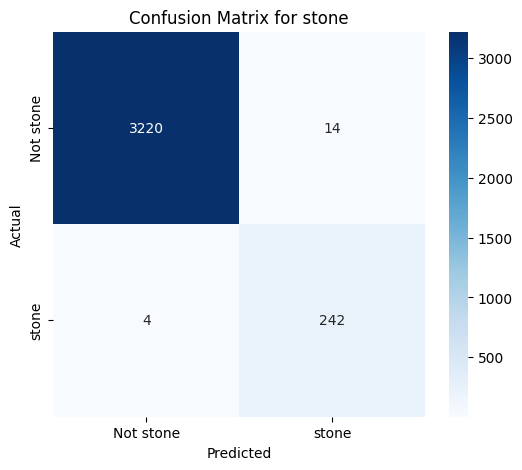

              precision    recall  f1-score   support

   Not stone       1.00      1.00      1.00      3234
       stone       0.95      0.98      0.96       246

    accuracy                           0.99      3480
   macro avg       0.97      0.99      0.98      3480
weighted avg       0.99      0.99      0.99      3480



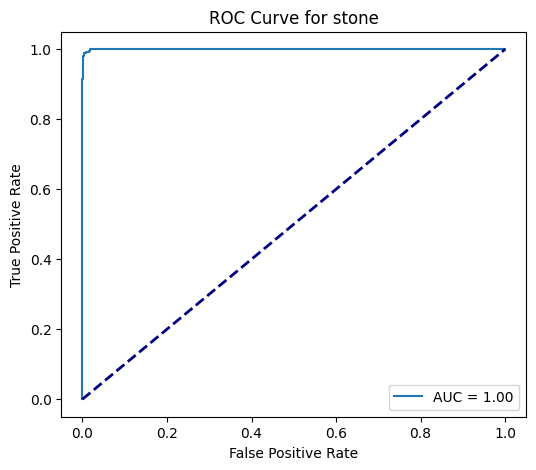

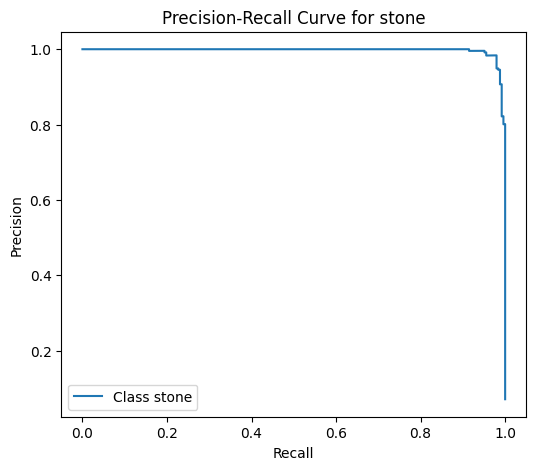

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training for class: tile


100%|██████████| 218/218 [01:16<00:00,  2.86it/s]


Epoch 1/6, Loss: 0.1978


100%|██████████| 218/218 [01:15<00:00,  2.88it/s]


Epoch 2/6, Loss: 0.0533


100%|██████████| 218/218 [01:14<00:00,  2.91it/s]


Epoch 3/6, Loss: 0.0248


100%|██████████| 218/218 [01:15<00:00,  2.88it/s]


Epoch 4/6, Loss: 0.0135


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 5/6, Loss: 0.0076


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 6/6, Loss: 0.0062
Test Accuracy for tile: 98.94%


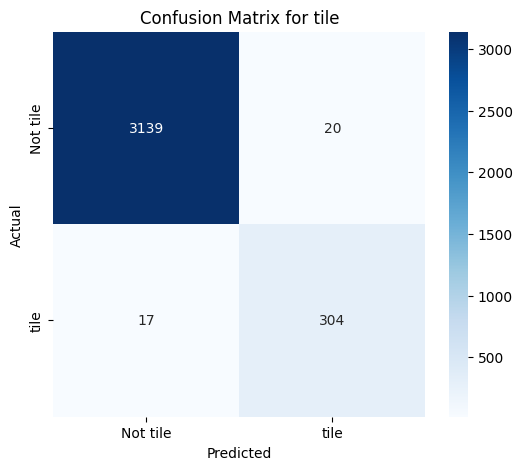

              precision    recall  f1-score   support

    Not tile       0.99      0.99      0.99      3159
        tile       0.94      0.95      0.94       321

    accuracy                           0.99      3480
   macro avg       0.97      0.97      0.97      3480
weighted avg       0.99      0.99      0.99      3480



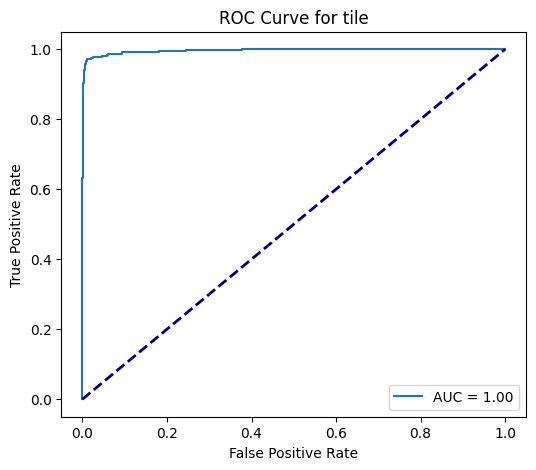

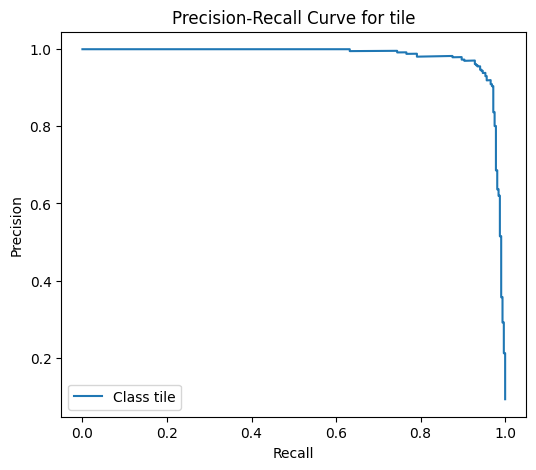

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training for class: wood


100%|██████████| 218/218 [01:16<00:00,  2.86it/s]


Epoch 1/6, Loss: 0.1786


100%|██████████| 218/218 [01:14<00:00,  2.91it/s]


Epoch 2/6, Loss: 0.0476


100%|██████████| 218/218 [01:15<00:00,  2.87it/s]


Epoch 3/6, Loss: 0.0211


100%|██████████| 218/218 [01:15<00:00,  2.89it/s]


Epoch 4/6, Loss: 0.0141


100%|██████████| 218/218 [01:15<00:00,  2.88it/s]


Epoch 5/6, Loss: 0.0096


100%|██████████| 218/218 [01:15<00:00,  2.87it/s]


Epoch 6/6, Loss: 0.0062
Test Accuracy for wood: 98.99%


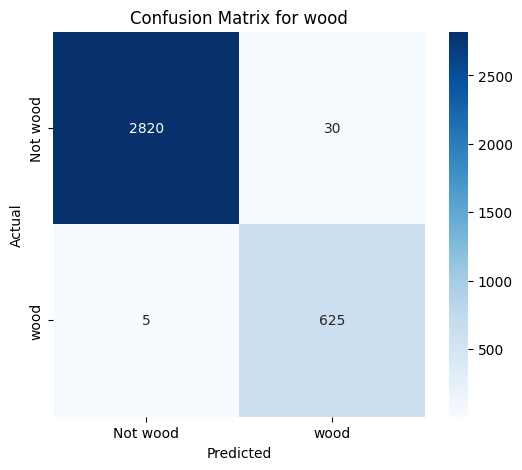

              precision    recall  f1-score   support

    Not wood       1.00      0.99      0.99      2850
        wood       0.95      0.99      0.97       630

    accuracy                           0.99      3480
   macro avg       0.98      0.99      0.98      3480
weighted avg       0.99      0.99      0.99      3480



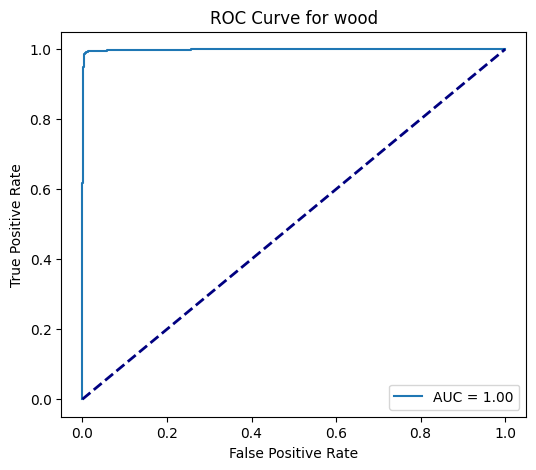

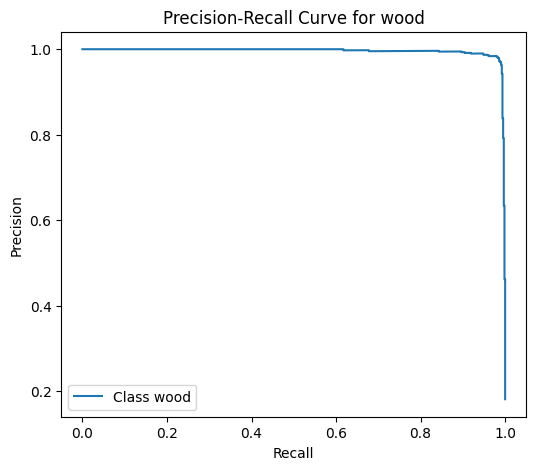

In [ ]:
from google.colab import drive
import zipfile
import os
import numpy as np
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import torch
from torchvision import transforms
from torchvision.models import mobilenet_v3_large
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from accelerate import Accelerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/class_fragments.zip"
extract_path = "extracted_files"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

DATA_DIR = os.path.join(extract_path, 'class_fragments')
classes = ["brick", "concrete", "foam", "general_w", "gypsum_board", "pipes", "plastic", "stone", "tile", "wood"]

def create_dataframe(directory, selected_label):
    image_paths, labels = [], []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, image_name))
                labels.append(1 if label == selected_label else 0)
    return image_paths, labels

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = self.transform(img)
        return {"pixel_values": img, "labels": torch.tensor(self.labels[idx], dtype=torch.long)}

for selected_label in classes:
    print(f"Training for class: {selected_label}")
    image_paths, labels = create_dataframe(DATA_DIR, selected_label)

    x_train, x_test, y_train, y_test = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )

    model = mobilenet_v3_large(pretrained=True)
    model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, 2)

    train_dataset = ImageDataset(x_train, y_train, transform)
    test_dataset = ImageDataset(x_test, y_test, transform)

    BATCH_SIZE = 64
    EPOCHS = 6
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    accelerator = Accelerator()
    model, optimizer, train_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, test_loader)

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for batch in tqdm(train_loader):
            pixel_values, labels = batch["pixel_values"].to(device), batch["labels"].to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values)
            loss = criterion(outputs, labels)
            accelerator.backward(loss)
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}")

    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            pixel_values, labels = batch["pixel_values"].to(device), batch["labels"].to(device)
            outputs = model(pixel_values)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())

    print(f"Test Accuracy for {selected_label}: {100 * np.mean(np.array(all_preds) == np.array(all_labels)):.2f}%")

    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not " + selected_label, selected_label], yticklabels=["Not " + selected_label, selected_label])
    plt.title(f"Confusion Matrix for {selected_label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print(classification_report(all_labels, all_preds, target_names=["Not " + selected_label, selected_label]))

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {selected_label}')
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f'Class {selected_label}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {selected_label}')
    plt.legend()
    plt.show()

# Модель MobileNetV3(large)(архітектура)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


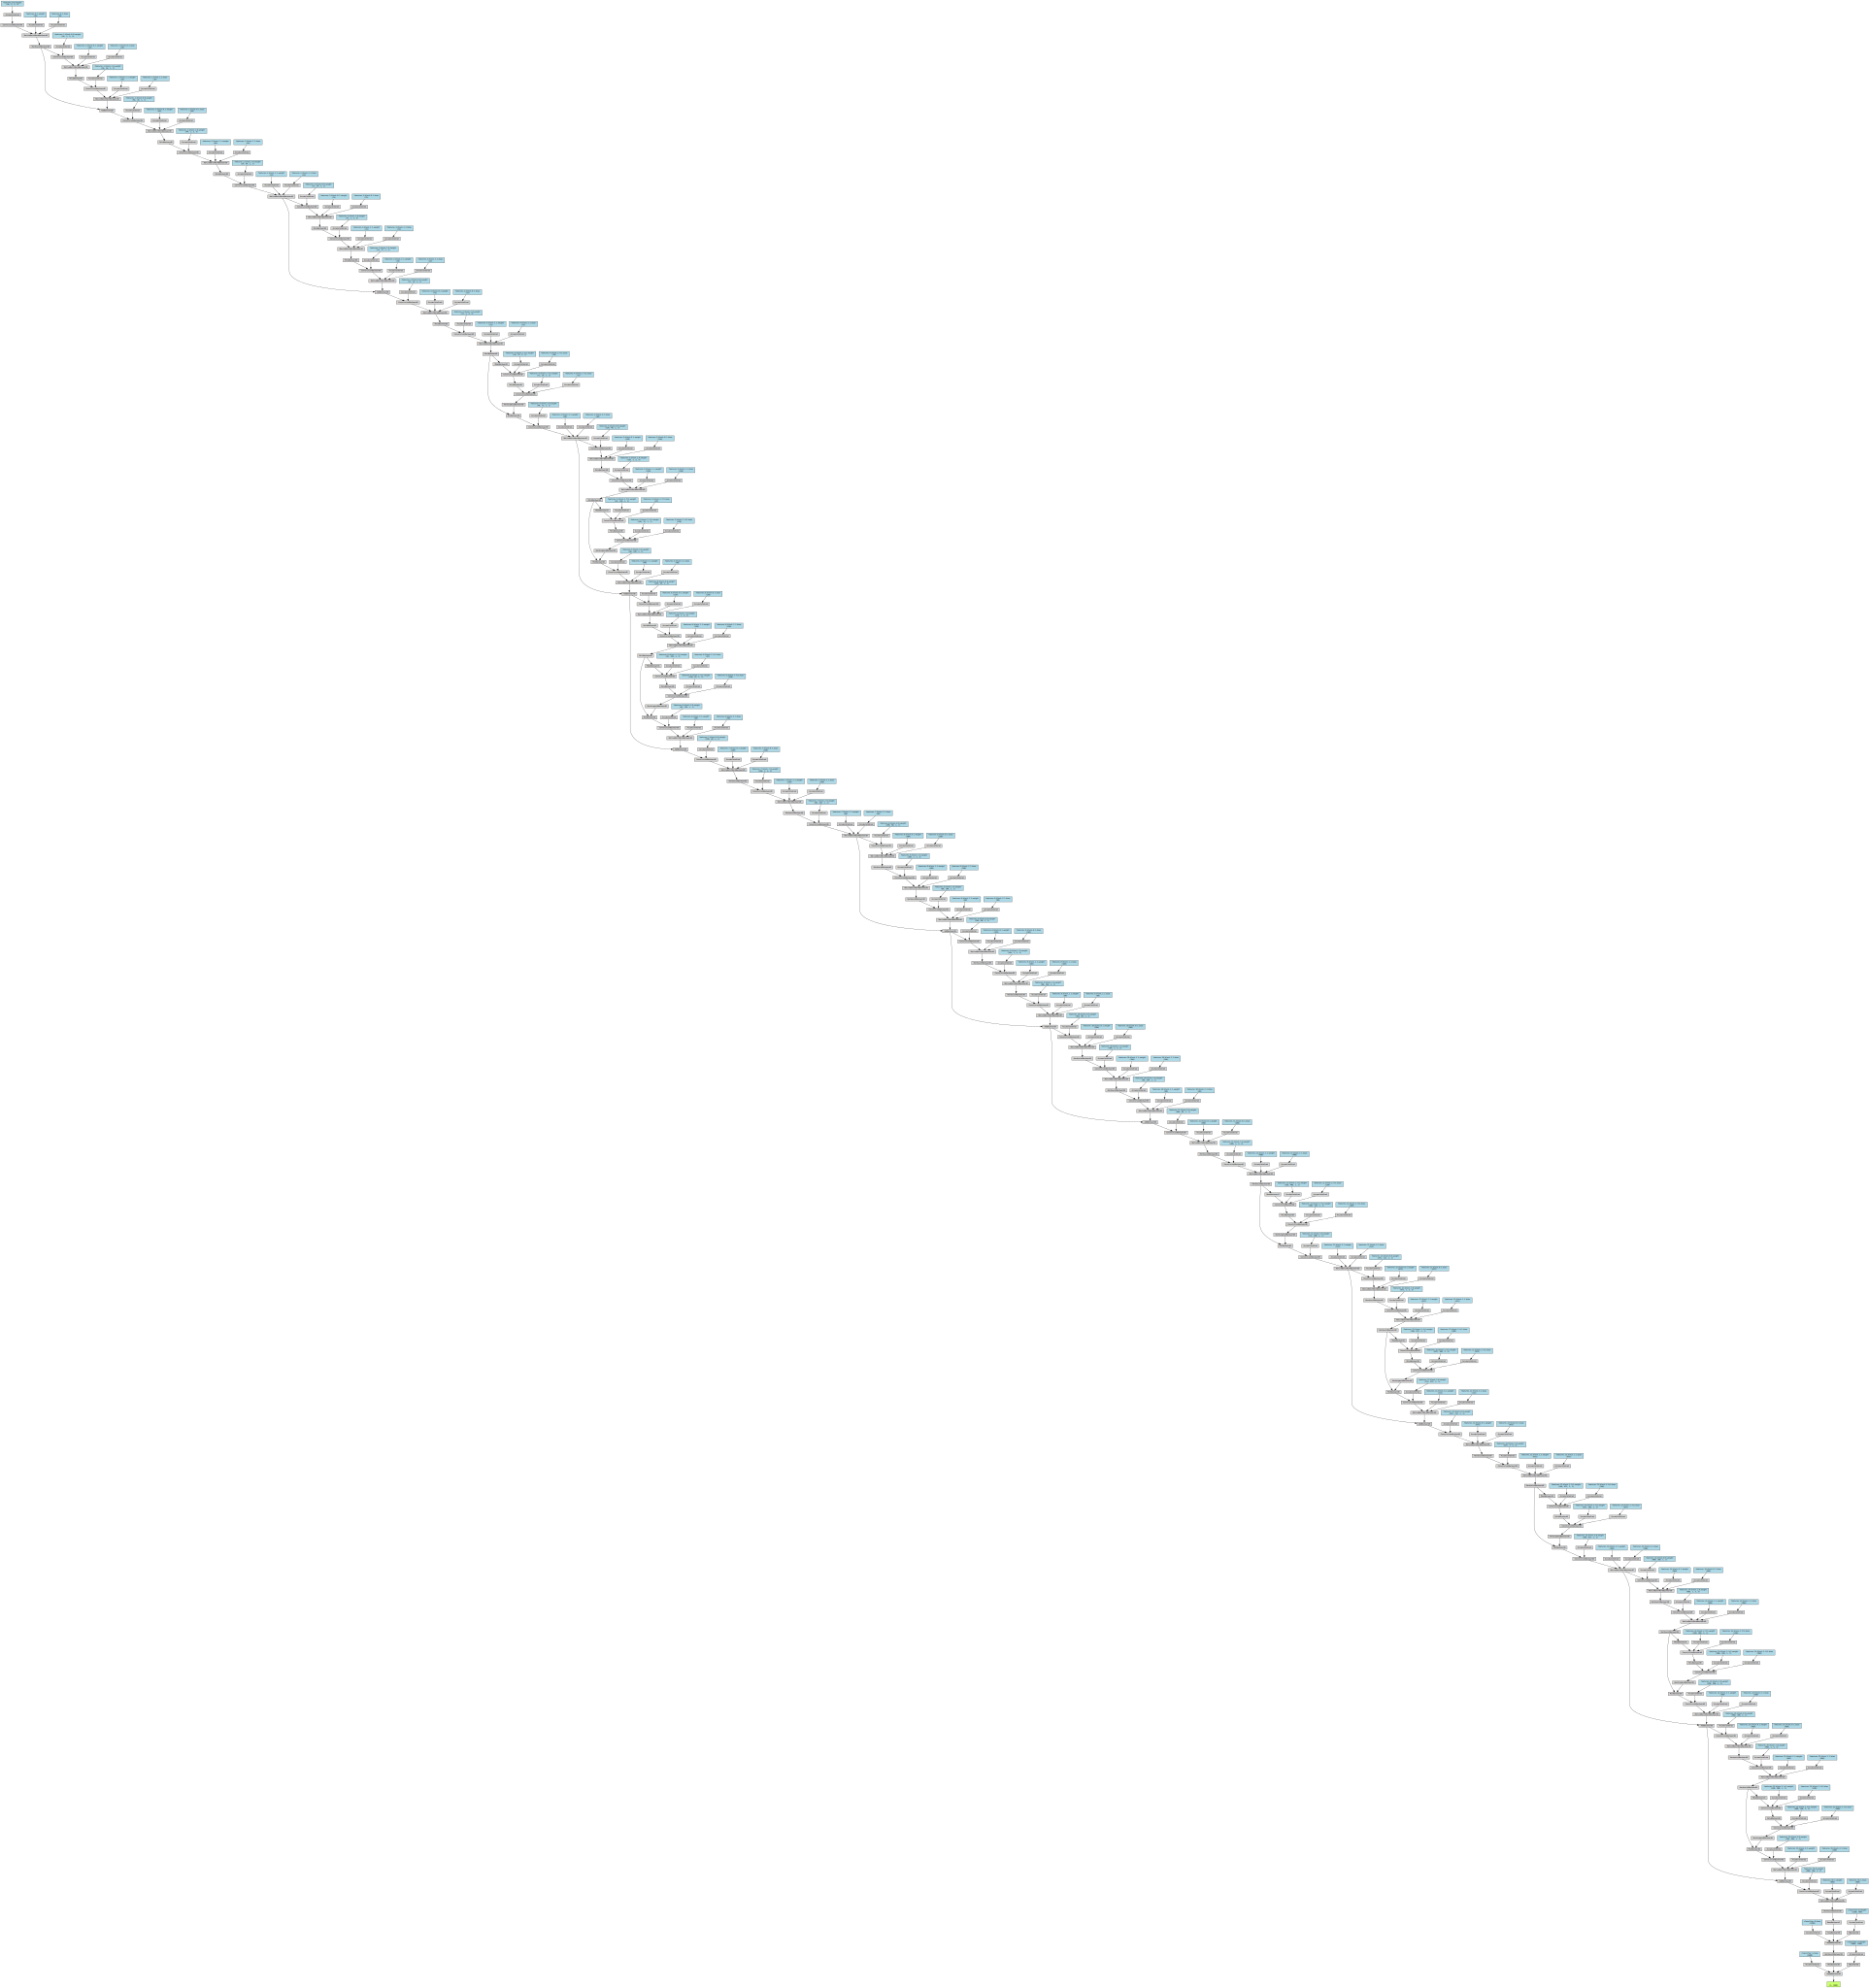

In [ ]:
import torch
from torchviz import make_dot
from torchvision.models import mobilenet_v3_large
from IPython.display import display, SVG

model = mobilenet_v3_large(pretrained=True)

dummy_input = torch.randn(1, 3, 224, 224)

output = model(dummy_input)

dot = make_dot(output, params=dict(model.named_parameters()))

file_path = '/content/mobilenetv3_model'
dot.render(file_path, format='svg')

display(SVG(filename=f'{file_path}.svg'))

In [ ]:
import torch
from torchvision.models import mobilenet_v3_large

model = mobilenet_v3_large(pretrained=True)

def count_parameters(model):
    total_params = 0
    param_count_per_layer = {}

    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        param_count_per_layer[name] = num_params

    return total_params, param_count_per_layer

total_params, param_count_per_layer = count_parameters(model)

print(f"Загальна кількість параметрів: {total_params}")

for layer_name, param_count in param_count_per_layer.items():
    print(f"{layer_name}: {param_count}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Загальна кількість параметрів: 5483032
features.0.0.weight: 432
features.0.1.weight: 16
features.0.1.bias: 16
features.1.block.0.0.weight: 144
features.1.block.0.1.weight: 16
features.1.block.0.1.bias: 16
features.1.block.1.0.weight: 256
features.1.block.1.1.weight: 16
features.1.block.1.1.bias: 16
features.2.block.0.0.weight: 1024
features.2.block.0.1.weight: 64
features.2.block.0.1.bias: 64
features.2.block.1.0.weight: 576
features.2.block.1.1.weight: 64
features.2.block.1.1.bias: 64
features.2.block.2.0.weight: 1536
features.2.block.2.1.weight: 24
features.2.block.2.1.bias: 24
features.3.block.0.0.weight: 1728
features.3.block.0.1.weight: 72
features.3.block.0.1.bias: 72
features.3.block.1.0.weight: 648
features.3.block.1.1.weight: 72
features.3.block.1.1.bias: 72
features.3.block.2.0.weight: 1728
features.3.block.2.1.weight: 24
features.3.block.2.1.bias: 24
features.4.block.0.0.weight: 1728
features.4.block.0.1.weight: 72
features.4.block.0.1.bias: 72
features.4.block.1.0.weight: 1

In [ ]:
def count_layers(model):
    return sum(1 for _ in model.modules())

total_layers = count_layers(model)

print(f"Загальна кількість шарів: {total_layers}")

Загальна кількість шарів: 255
